In [20]:
import sys 
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
sys.path.insert(0, "../../")
import spycone_pkg.spycone as spy

# Gene-level workflow

## Prepare the dataset

We use a time series dataset of influenza infection with 9 time points. 

In [21]:
#sample data
import os
os.chdir("/nfs/proj/spycone/")


influ = pd.read_csv("./spycone_pkg/data/covid_hs/normticonerhino_wide.csv", dtype={'entrezid': str})
gene_list = influ['entrezid'] 
symbs = influ['symbol']

flu_ts = influ.iloc[:,3:] ##filter out the entrez id and gene id column


Import expression data with `DataSet` which stores the count matrix, list of gene ID, number of time points, and number of replicates. \
`ts` : time series data values with columns as each sample e.g. the order of the columns should be **sample1_rep1**, **sample1_rep2**, **sample2_rep1**, **sample2_rep2** and so on.... \
`gene_id` : the pandas series or list of gene id (can be entrez gene id or ensembl gene id) \
`species` : specify the species ID \
`reps1` : Number of replicates \
`timepts` : Number of time points \
`discreization_steps` : Steps to discretize the data values

In [22]:
flu_dset = spy.dataset(ts=flu_ts, 
                        gene_id = gene_list, 
                        species=9606,
                        keytype="entrezgeneid",
                        reps1 = 5, 
                        timepts = 9,
                        discretization_steps = [20,20])

Import biological network of your choice with `BioNetwork`, Spycone provides Biogrid, IID network in entrez ID as node name. Please specify the keytype if you are using a different ID.

In [23]:
bionet = spy.BioNetwork("human")

## Preprocessing

Filtering out genes that has expression across all time points lower than 1. By giving the biological network, it removes genes from the dataset that are not in the network.

In [24]:
spy.preprocess(flu_dset)

Input data dimension: (5, 19463, 9)
Removed 0 with 0 values.
Filtered data: (5, 19463, 9)


In [33]:
import networkx as nx
path = os.path.join("./spycone_pkg/spycone",f'data/network/9606_biogrid_entrez.tab')
g = nx.read_edgelist(path=path)


## Clustering

`clustering` create clustering object that provides varies algorithms and result storage.

In [6]:
asclu = spy.clustering(flu_dset, algorithm='hierarchical', metrics="correlation", input_type="expression", n_clusters=10, composite=False)
c = asclu.find_clusters()

ValueError: Expected 2D array, got 1D array instead:
array=[].
Reshape your data either using array.reshape(-1, 1) if your data has a single feature or array.reshape(1, -1) if it contains a single sample.

visualizing clustering

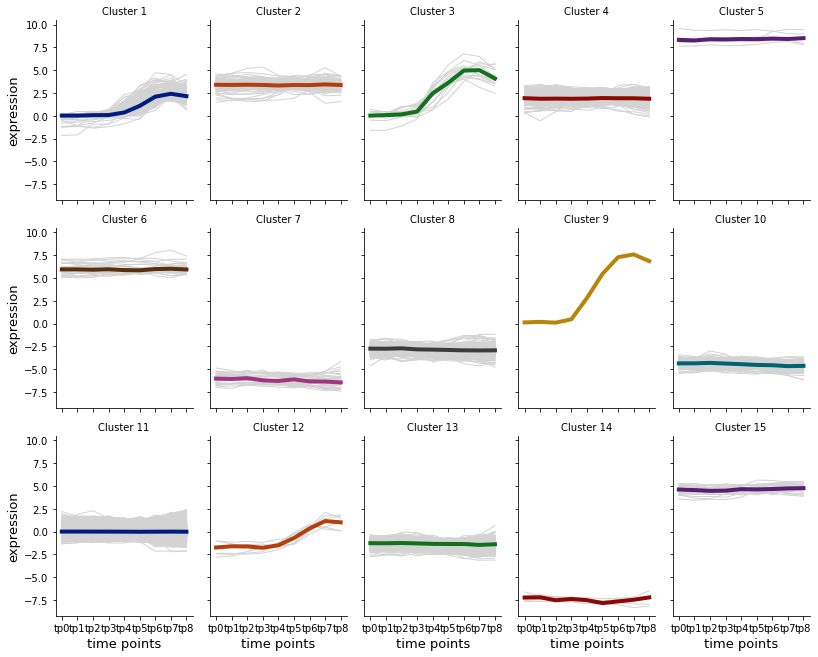

In [ ]:
%matplotlib inline
spy.vis_all_clusters(asclu, col_wrap=5)

## Gene set enrichment analysis

Perform gene set enrichment analysis using `clusters_gsea`. Change the gene_sets parameter into the choice of your knowledge base or gene set database, e.g. Reactome, KEGG, etc. Use `spy.list_genesets` to view the available knowledge base.

In [ ]:
spy.list_genesets(organism="human")[0:5]

['ARCHS4_Cell-lines',
 'ARCHS4_IDG_Coexp',
 'ARCHS4_Kinases_Coexp',
 'ARCHS4_TFs_Coexp',
 'ARCHS4_Tissues']

In [ ]:
asclu_go, _ = spy.clusters_gsea(flu_dset, 9606, method="gseapy", gene_sets = ['GO_Biological_Process_2018'])

2022-02-02 22:47:53,533 Warning: No enrich terms using library GO_Biological_Process_2018 when cutoff = 0.05
2022-02-02 22:48:27,057 Warning: No enrich terms using library GO_Biological_Process_2018 when cutoff = 0.05
2022-02-02 22:48:43,533 Warning: No enrich terms using library GO_Biological_Process_2018 when cutoff = 0.05


---------Gene Set Enrichment Result---------

Cluster 11  found enriched in 246 terms.
Cluster 13  found enriched in 1 terms.
Cluster 4  found enriched in 0 terms.
Cluster 2  found enriched in 1 terms.
Cluster 8  found enriched in 9 terms.
Cluster 14  found enriched in 61 terms.
Cluster 15  found enriched in 1 terms.
Cluster 1  found enriched in 150 terms.
Cluster 6  found enriched in 0 terms.
Cluster 10  found enriched in 1 terms.
Cluster 3  found enriched in 124 terms.
Cluster 7  found enriched in 0 terms.
Cluster 12  found enriched in 190 terms.
Cluster 5  found enriched in 17 terms.
Cluster 9  found enriched in 17 terms.
-----END-----


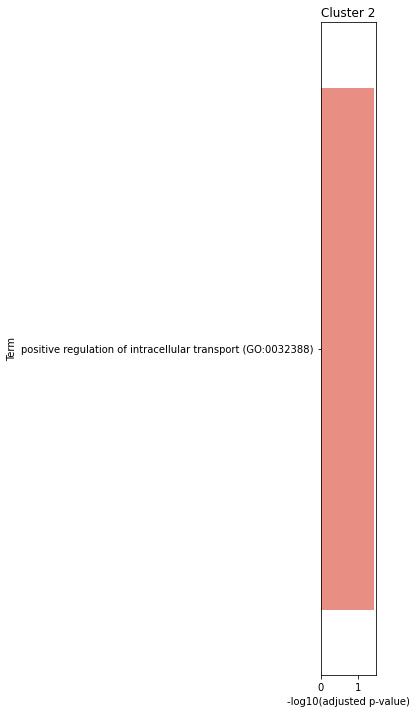

In [ ]:
spy.gsea_plot(asclu_go, cluster=11, nterms=15)

## Run DOMINO

In [ ]:
mod = spy.run_domino(asclu, network_file="./spycone_pkg/spycone/data/network/9606_biogrid_entrez.tab")

start running DOMINO...
---------Network enrichment Result---------

Cluster 11 found 37 module(s).
Cluster 13 found 4 module(s).
Cluster 4 found 15 module(s).
Cluster 2 found 2 module(s).
Cluster 8 found 1 module(s).
Cluster 14 found 1 module(s).
Cluster 15 found 7 module(s).
Cluster 1 found 10 module(s).
Cluster 6 found 7 module(s).
Cluster 10 found 14 module(s).
Cluster 3 found 3 module(s).
Cluster 7 found 6 module(s).
Cluster 12 found 1 module(s).
Cluster 5 found 3 module(s).
Cluster 9 found 0 module(s).
-----END-----


To visualize the modules, use `vis_modules`. 

In [21]:
%matplotlib inline
spy.vis_modules(mod, flu_dset, cluster=11, size=1)

AttributeError: 'DataSet' object has no attribute 'isoobj'

It is also possible to visualize modules with javascript, use `vis_better_modules` and input a desired directory, the function will generate a interactive html file.

vis_better_modules(flu_dset, mods, cluster=5, dir='/nfs/proj/spycone/calu_covid_0.05_8/')